In [1]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle     # method for save trained/fit model/s
import joblib     # method for save trained/fit model/s

import sklearn as sk

                             
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset

from sklearn import svm                                 #  support vector machine (SVM) learning method
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (classification_report, 
                             balanced_accuracy_score, 
                             confusion_matrix, 
                             f1_score)

from imblearn.metrics import classification_report_imbalanced
from pandas_profiling import ProfileReport 


In [2]:
accepted_df = pd.read_csv(Path('/Users/will/Downloads/archive/accepted_2007_to_2018Q4.csv.gz'), compression='gzip', low_memory=False)


In [3]:
accepted_df.tail() 
accepted_df = accepted_df[[
    'id', 
    'loan_amnt', 
    'term','int_rate', 
    'sub_grade',
    'home_ownership', 
    'addr_state',
    'emp_length',
    'grade',
    'annual_inc',
    'loan_status', 
    'dti',
    'mths_since_recent_inq', 
    'revol_util', 
    'bc_open_to_buy', 
    'bc_util', 
    'num_op_rev_tl']]

accepted_df = accepted_df.dropna() 
q_low = accepted_df["annual_inc"].quantile(0.08)
q_hi  = accepted_df["annual_inc"].quantile(0.92)
accepted_df = accepted_df[(accepted_df["annual_inc"] < q_hi) & (accepted_df["annual_inc"] > q_low)]
accepted_df = accepted_df[(accepted_df['dti'] <=45)]
q_hi  = accepted_df['bc_open_to_buy'].quantile(0.95)
accepted_df = accepted_df[(accepted_df['bc_open_to_buy'] < q_hi)]
accepted_df = accepted_df[(accepted_df['bc_util'] <=160)]
accpeted_df= accepted_df[(accepted_df['revol_util'] <=150)]
accepted_df = accepted_df[(accepted_df['num_op_rev_tl'] <=35)]
profile = ProfileReport (accepted_df, title = 'Loans Defaults Prediction', html = {'style': {'full_width': True }}) 
profile




Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
cleaner_app_type = {"term": {" 36 months": 1.0, " 60 months": 2.0},
                    "sub_grade": {"A1": 1.0, "A2": 2.0, "A3": 3.0, "A4": 4.0, "A5": 5.0,
                                  "B1": 11.0, "B2": 12.0, "B3": 13.0, "B4": 14.0, "B5": 15.0,
                                  "C1": 21.0, "C2": 22.0, "C3": 23.0, "C4": 24.0, "C5": 25.0,
                                  "D1": 31.0, "D2": 32.0, "D3": 33.0, "D4": 34.0, "D5": 35.0,
                                  "E1": 41.0, "E2": 42.0, "E3": 43.0, "E4": 44.0, "E5": 45.0,
                                  "F1": 51.0, "F2": 52.0, "F3": 53.0, "F4": 54.0, "F5": 55.0,
                                  "G1": 61.0, "G2": 62.0, "G3": 63.0, "G4": 64.0, "G5": 65.0,
                                    },
                     "emp_length": {"< 1 year": 0.0, '1 year': 1.0, '2 years': 2.0, '3 years': 3.0, '4 years': 4.0, 
                                   '5 years': 5.0, '6 years': 6.0, '7 years': 7.0, '8 years': 8.0, '9 years': 9.0,
                                   '10+ years': 10.0 }
                   }
accepted_df = accpeted_df.replace(cleaner_app_type)

In [8]:
accepted_df['loan_status'].value_counts() 

Fully Paid            678190
Current               529948
Charged Off           177405
Late (31-120 days)     14095
In Grace Period         5585
Late (16-30 days)       2745
Default                   23
Name: loan_status, dtype: int64

In [9]:
array = ['Charged Off', 'Fully Paid']
accepted_df = accepted_df.loc[accepted_df['loan_status'].isin(array)]
accepted_df.head() 

,id,loan_amnt,term,int_rate,sub_grade,home_ownership,addr_state,emp_length,grade,annual_inc,loan_status,dti,mths_since_recent_inq,revol_util,bc_open_to_buy,bc_util,num_op_rev_tl
0,68407277,3600.0,1.0,13.99,24.0,MORTGAGE,PA,10.0,C,55000.0,Fully Paid,5.91,4.0,29.7,1506.0,37.2,4.0
2,68341763,20000.0,2.0,10.78,14.0,MORTGAGE,IL,10.0,B,63000.0,Fully Paid,10.78,10.0,56.2,2737.0,55.9,4.0
4,68476807,10400.0,2.0,22.45,51.0,MORTGAGE,PA,3.0,F,104433.0,Fully Paid,25.37,1.0,64.5,4567.0,77.5,7.0
7,67275481,20000.0,1.0,8.49,11.0,MORTGAGE,SC,10.0,B,85000.0,Fully Paid,17.61,8.0,5.7,13674.0,5.7,3.0
8,68466926,10000.0,1.0,6.49,2.0,RENT,PA,6.0,A,85000.0,Fully Paid,13.07,1.0,34.5,8182.0,50.1,13.0


In [10]:
cleaner_app_type1 = {"loan_status": { "Fully Paid": 1.0, "Charged Off": 0.0}}
accepted_df = accepted_df.replace(cleaner_app_type1)

<AxesSubplot:>

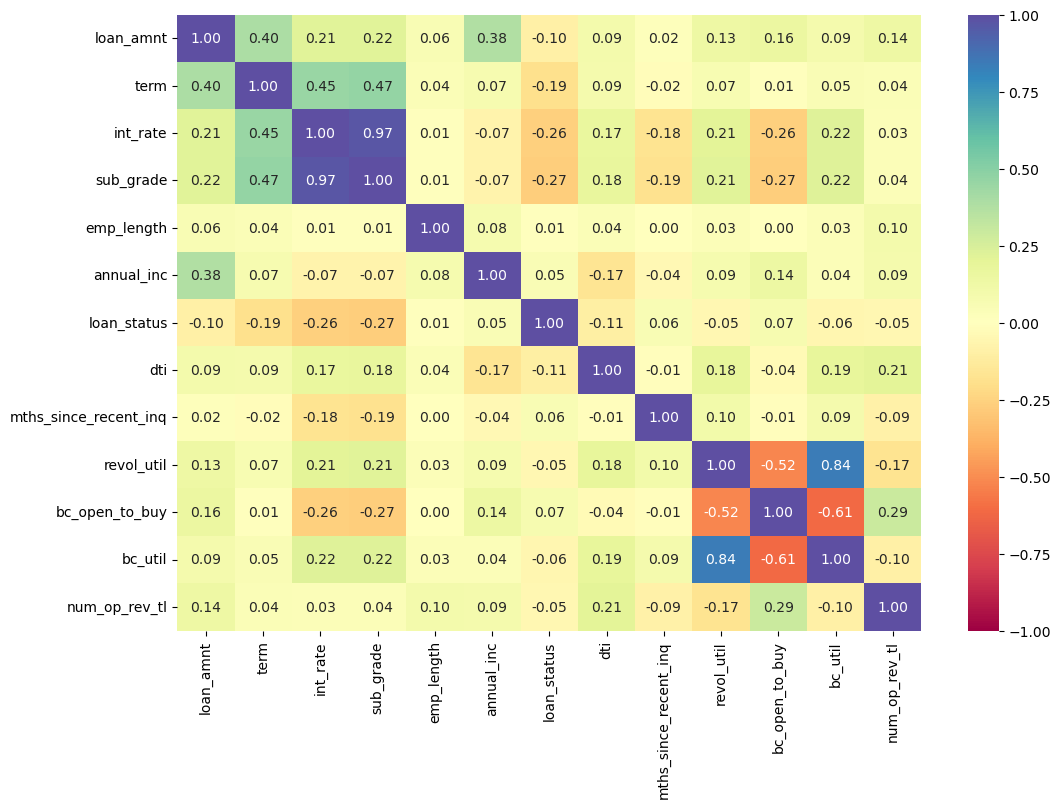

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(accepted_df.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')